# Single Layer NN using TensorFlow
The following code classifies MNIST dataset using a single layer NN with softmax activation function, Cross entropy loss function and Mini-batch Technique

## Softmax Function
$$
\sigma(z){_j} = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_j}}
$$

## Cross Entropy
$$
Cross Entropy = -{\sum_{i=1}^{i=n}Y_{i}^{'}.\log(Y^i)}
$$

## Mini-batch Technique
Taking a btach of 100 images in a single iteration. 2 Reasons to use it:
1. Analyzing Single image results in a curvy descent. Knowledge of 100 images at a single time gives a more precise consensus of the gradient
2. We do distributed processing using GPUs on which matrix multiplications works faster. (Optimised for GPUs)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import scipy as sp


/Users/binxinru/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Functions defined by Matt to compute Hessian 

In [2]:
def jacobian_piece(vect, parameters, index):
  dfx_i = tf.slice(vect, begin=[index,0] , size=[1,1])
  ddfx_i = tf.gradients(dfx_i, parameters)[0] 
  return ddfx_i

def jacobian(y_flat, x):
    n = y_flat.shape[0]
    #
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float32, size=n),
    ]
    #
    _, jacobian = tf.while_loop(
        lambda j, _: j < n,
        lambda j, result: (j+1, result.write(j, jacobian_piece(y_flat, x, j))),
        loop_vars,swap_memory=True)
    #
    return jacobian.stack()

## Load Data
MNIST dataset is a handwritten numbers dataset. We download it from tensorflow examples.<br/>
Make sure to change the path according to your need

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("tutorials/data/MNIST/", one_hot=True)
print("Extraction of images is complete.")

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tutorials/data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tutorials/data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting tutorials/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting tutorials/data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extraction of images is complete.


## TensorFlow Placeholders
Tensorflow placeholders are like variables waiting for input. They are access points to the computational graphs on which we can just feed into the graph.

In [4]:
n_input  = 784
n_output = 10
X = tf.placeholder(tf.float32, [None, 784])
# Concatenate all parameters 
parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_output,1]), tf.zeros([n_output, 1])],0))

# Construct weight matrix and bias vector from parameters
idx_from = 0 
W = tf.reshape(tf.slice(parameters, begin=[idx_from, 0], size=[n_input*n_output, 1]), [n_input, n_output])
idx_from = idx_from + n_input*n_output
b = tf.reshape(tf.slice(parameters, begin=[idx_from, 0], size=[n_output, 1]), [n_output])

# Placeholder for correct label which will help us to compute the accuracy and cross-entropy of our model.
Y_true = tf.placeholder(tf.float32, [None, 10])

## Model
Our model is a Softmax Function applied over the weighted sum of the image pixels along with a bias added to it.
$$
Y = softmax(X.W + b)
$$
Where,<br/>
X = flattened image vector (1, 784)<br/>
W = Weights matrix of shape (784, 10) -> 784 weights for each pixel and 1 column for each class [0-9]<br/>
b = bias vector with 10 columns, each column representing a class<br/>

Since, we are using mini-batch technique. We will use X as a flattened image matrix with 100 rows, each row representing a flattened image.

In [5]:
Y = tf.nn.softmax(tf.matmul(X, W) + b)

## Loss Function
As discussed above we are using cross-entropy loss function
$$
Cross Entropy = -{\sum_{i=1}^{i=n}Y_{i}^{'}.\log(Y^i)}
$$

In [6]:
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y))

## % of correct answers found in batch
Graph nodes to compute the accuracy of our model

In [7]:
is_correct = tf.equal(tf.argmax(Y_true, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

## Optimizer
We are using the simplest Gradient Descent technique as an optimizer, with a learning rate of 0.003. This means we will be adding the 0.3% value of our gradient to the weights everytime. 

## Hessian computation
H = $\bigtriangledown (\bigtriangledown Cross Entropy )$

In [8]:
# Optimizer 
optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)

# Hessian computation 
grad_step =   tf.gradients(cross_entropy,parameters)[0]
hess       = jacobian(grad_step, parameters)


## Training
Time to train the system. We run 2000 iterations on the train step and compute the accuracy and cross-entropy on each step. Compute the Hessian every k iterations 

In [10]:
# Session run
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# no. of iterations
n_iter = 200

# Hessian computation interval 
k = 100

# test set
test_data = {X: mnist.test.images, Y_true: mnist.test.labels}

# lists to hold train accuracy and cross-entropy
acc_train_li = []
cross_train_li = []

# lists to hold test accuracy and cross-entropy
acc_test_li = []
cross_test_li = []

for i in range(n_iter):
    # load batch of images and correct answer
    bacth_X, batch_Y = mnist.train.next_batch(100)
    train_data = {X: bacth_X, Y_true: batch_Y}
    
    # train
    sess.run(train_step, feed_dict=train_data)
    
    # find accuracy and cross entropy on current data
    a, c = sess.run([accuracy, cross_entropy], feed_dict=train_data)
    acc_train_li.append(a)
    cross_train_li.append(c)
    
    # find accuracy and cross entropy on test data
    a, c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
    acc_test_li.append(a)
    cross_test_li.append(c)
    
    # Save accuracy and cross entropy data 
    print("save accuracy results")
    np.save('acc_train_li_softmax' ,acc_train_li)
    np.save('cross_train_li_softmax' ,cross_train_li)
    np.save('acc_test_li_softmax' ,acc_test_li)
    np.save('cross_test_li_softmax' ,cross_test_li)
    
    # Hessian computation
    if (i % k ==0):
        # compute Hessian after every k iterations
        print('compute hessian matrix ')
        grad = sess.run(grad_step, feed_dict=train_data)
        H = sess.run(hess, feed_dict=train_data)
        # save Hessian computed 
        Hessian = np.squeeze(H)
        filename = "Hessian_softmax" +str(i)
        np.save(filename,Hessian)
        print('Hessan matrix saved')
    else:
         pass

save accuracy results
compute hessian matrix 
Hessan matrix saved
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accuracy results
save accur

## Check Hessian
Hessian should have size 7850 x 7850 because:  
 1. $W$ matrix has size 784x10  >  7840 weights
 2. $b$ vector has size 10x1  >  10 bias 
 3. $Parameter$ vector has size 7850  >  All 7850 parameters

In [17]:
# Check shape
print("Hessian shape = " + str(Hessian.shape))

# Check Hessian
print(Hessian)

# Check eigvalues
# H_eigvalue = np.linalg.eigh(H2)
H_eigvalue = sp.sparse.linalg.eigsh(Hessian,7849)
print("Hessian eigvalues")
print(H_eigvalue)

Hessian shape = (7850, 7850)
Hessian eigvalues
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.3928221  -0.3910387
  -0.5267397 ]
 [ 0.          0.          0.         ... -0.3910387   3.3268073
  -0.33039576]
 [ 0.          0.          0.         ... -0.5267397  -0.33039576
   2.2826614 ]]


## Plot the graph
We plot 2 graphs:
1. Accuracy graph - To display the accuracy on the train data and test data
2. Cross-entropy graph - To display the cross-entropy loss on train and test data

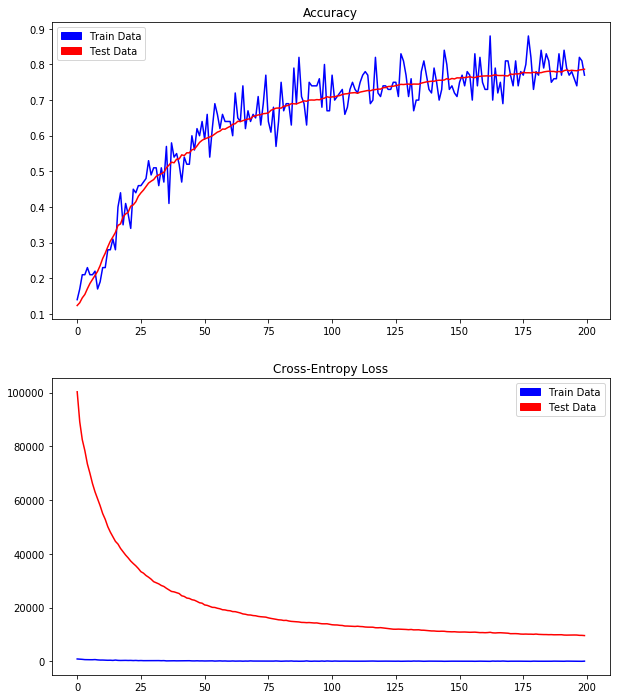

In [18]:
x = list(range(n_iter))

blue_patch = mpatches.Patch(color='blue', label='Train Data')
red_patch = mpatches.Patch(color='red', label='Test Data')

plt.figure(0, figsize=(10, 12))

plt.subplot(211)
plt.title("Accuracy")
plt.legend(handles=[blue_patch, red_patch])
plt.plot(x, acc_train_li, color='blue')
plt.plot(x, acc_test_li, color='red')

plt.subplot(212)
plt.legend(handles=[blue_patch, red_patch])
plt.title("Cross-Entropy Loss")
plt.plot(x, cross_train_li, color='blue')
plt.plot(x, cross_test_li, color='red')

plt.savefig("acc_loss.png")

plt.show()

## Final Loss and Accuracy
Let's have a peek at the final loss and accuracy of the training and test sets

In [12]:
print('Train Set Accuracy: {} \t Train Set cross-entropy Loss: {}'.format(acc_train_li[-1], cross_train_li[-1]))
print('Test Set Accuracy: {} \t Test Set cross-entropy Loss: {}'.format(acc_test_li[-1], cross_test_li[-1]))

Train Set Accuracy: 0.7699999809265137 	 Train Set cross-entropy Loss: 116.37315368652344
Test Set Accuracy: 0.7865999937057495 	 Test Set cross-entropy Loss: 9628.29296875
